# Random Forest para classificação de Notícias

## Descrição do dataset

O dataset utilizado para benchmark de algoritmos de classificação é o [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset). É um dataset que classifica os tipos de notícias com base no título e uma curta descrição delas.

O dataset contém por volta de 210 mil títulos de notícias escritas entre 2012 e 2022 no website HuffPost. O HuffPost deixou de manter um arquivo extenso com as notícias algum tempo depois que o dataset foi primeiramente coletado em 2018, então não é mais possível coletar novas notícias para o dataset nos dias de hoje. Devido a essas mudanças no website, existem aproximadamente 200 mil títulos de notícias entre 2012 e maio de 2018, e 10 mil títulos de notícias entre maio de 2018 e 2022.

### Conteúdo

Cada registro no dataset consiste nos seguintes atributos:

- `category`: categoria à qual o artigo pertence.
- `headline`: o título do artigo de notícia.
- `authors`: lista de autores que contribuíram na escrita do artigo.
- `link`: link para o artigo original.
- `short_description`: resumo (_abstract_) do artigo de notícia.
- `date`: data de publicação do artigo.

No dataset, existe um total de 42 categorias de notícias. As 15 categorias que apresentam mais artigos são:

- POLITICS: 35602

- WELLNESS: 17945

- ENTERTAINMENT: 17362

- TRAVEL: 9900

- STYLE & BEAUTY: 9814

- PARENTING: 8791

- HEALTHY LIVING: 6694

- QUEER VOICES: 6347

- FOOD & DRINK: 6340

- BUSINESS: 5992

- COMEDY: 5400

- SPORTS: 5077

- BLACK VOICES: 4583

- HOME & LIVING: 4320

- PARENTS: 3955

## Random Forest

**Forest of Randomized Trees**, **Random Forest** ou **Random Decision Forest** é um método de aprendizagem conjunta (que utiliza múltiplos algoritmos de aprendizagem, no caso, Decision Trees) para classificação, regressão e outras tarefas e que opera construindo uma infinidade de arvores de decisão no momento do treinamento.

O Random Forest tem a capacidade de corrigir o hábito de _overfitting_ presente nos algoritmos de Árvores de Decisão (Decision Trees) e, geralmente, supera a perfomance delas. Apesar disso, a precisão dele é menor que o algoritmo de Árvores Impulsionadas por Gradiente (Gradient Boosted Trees). Notoriamente, a característica dos dados pode afetar na perfomance dos modelos.

Para a tarefa de classificação, a saída do Random Forest é a classe selecionada pela maioria das suas árvores. Para tarefas de regressão, a média ou a previsão média das árvores individuais é retornada.

### Scikit-Learn

A biblioteca do Scikit-Learn inclui dois algoritmos de média baseados em Árvores de Decisão aleatorizadas: o algoritmo RandomForest e o método Extra-Trees. Ambos os algoritmos são técnicas de pertubação e combinação especificamente projetadas para Decision Trees.

Assim como outros classificadores, essas técnicas devem ser ajustadas em duas matrizes (arrays):
- Um array `X` denso ou esparso de forma (`n_samples`, `n_features`) contendo as amostras de treinamento,
- E um array `Y` de forma (`n_samples`,) contendo os valores de destino (os valores _target_ ou classes labels).

No algoritmo RandomForest (seja para [classificação](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) ou [regressão](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)), cada árvore no conjunto é construída a partir de uma amostra extraída com substituição (amostra bootstrap) dos dados de treinamento presentes em `X`.

Além disso, ao ramificar os nós durante a construção da árvore, a melhor divisão é encontrada dentre todos os dados de entrada ou dentre um subconjunto aleatório de tamanho `max_features`.

O propósito dessas duas fontes de aleatoriedade é para diminuir a variância do estimador no algoritmo superando o problema de _overfitting_ (causado pela alta variância) presente nas Decision Trees individualmente. A aleatoriedade injetada no algoritmo produz árvores de decisão com certos erros de previsão desacoplados. Todavia, ao se tirar a média das previsões, alguns erros podem ser anulados.

Logo, o Random Forest obtém uma variância reduzida combinando diversas árvores, às vezes ao custo de um ligeiro aumento no viés das previsões. Na prática, essa redução da variância geralmente é significativa e resulta em um modelo geral melhor.

Por fim, em contraste com a versão original do Random Forest, a implementação do Scikit-Learn combina classificadores calculando a média de sua previsão probabilística, ao invés de permitir que cada classificador vote em uma única classe.

## Implementação

In [4]:
import pandas as pd   # Leitura dos dados
import numpy as np
import re
import spacy    # Pré-processamento dos dados
from sklearn.ensemble import RandomForestClassifier   # Modelo de classificação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


nlp = spacy.load('en_core_web_lg')   # Carregando pipeline do spaCy
STOP_WORDS = nlp.Defaults.stop_words

In [5]:
data = pd.read_json('News_Category_Dataset_v3.json', lines=True)   # Carregando dados

data  # Visualização geral

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [6]:
print("Algumas informações gerais:")
print(f"\tNo dataset, há {data.isna().sum().sum()} linhas nulas.")
print(f"\tO dataset contém a forma {data.shape}.")

Algumas informações gerais:
	No dataset, há 0 linhas nulas.
	O dataset contém a forma (209527, 6).


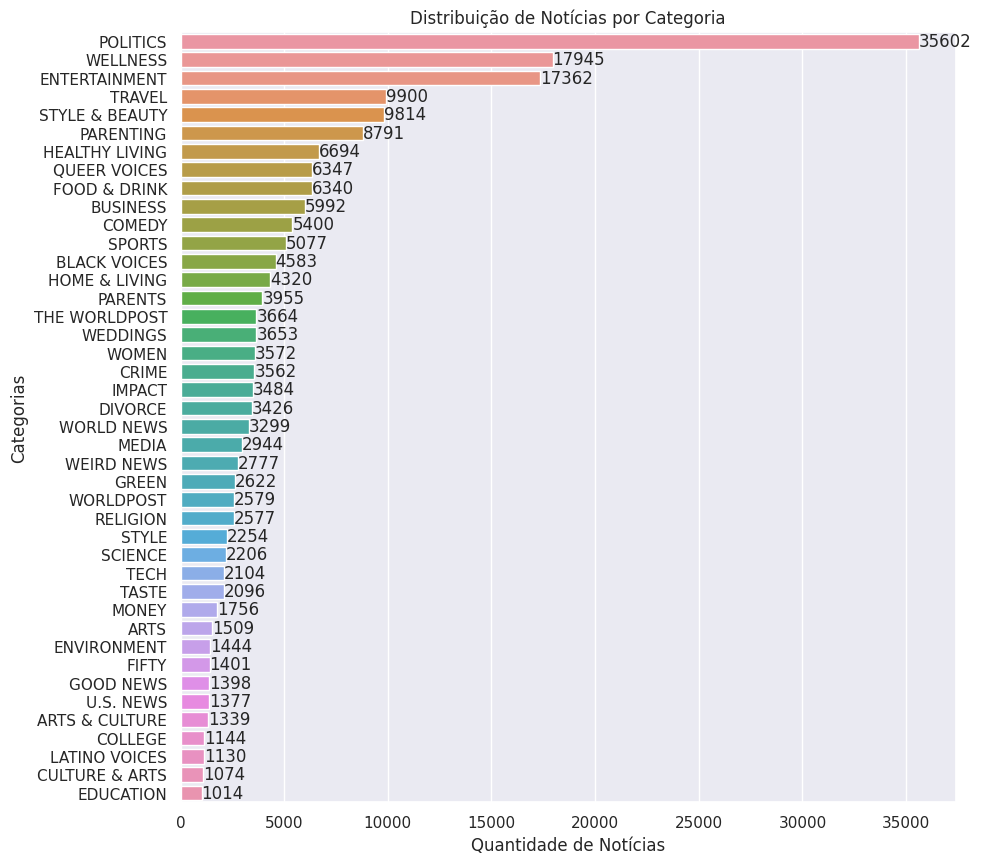

In [7]:
# Biblioteca pra visualização de gráficos
import seaborn as sns

sns.set(font_scale=1.0) # Definindo tamanho da fonte
counts = data.groupby(["category"])["category"].count()  # Contando valores por categoria
counts.sort_values(ascending=False, inplace=True) # Ordenando valores

ax = sns.barplot(y=counts.index, x=counts)  # Criando gráfico
ax.set(title='Distribuição de Notícias por Categoria')
ax.set(xlabel='Quantidade de Notícias', ylabel='Categorias') # Labels do gráfico
for i in ax.containers: # Valores das barras
    ax.bar_label(i,)
ax.figure.set_size_inches(10, 10) # Definição do tamanho do gráfico

In [8]:
data["feature_text"] = data["headline"] + ':' + data['short_description']
data = data[["feature_text", "category"]]

data.head()

,feature_text,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


In [9]:
def preprocessing(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    # text = re.sub(r"\[[^()]*\]","", text)
    # text = re.sub("\d+", "", text)
    # text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    text = [word for word in text.split() if word not in list(STOP_WORDS)]

    return ' '.join(text)

In [10]:
data['feautre_text'] = data['feature_text'].apply(preprocessing)
data.head()

/tmp/ipykernel_20803/2877245937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['feautre_text'] = data['feature_text'].apply(preprocessing)


,feature_text,category,feautre_text
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,over 4 million americans roll up sleeves omicr...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,"american airlines flyer charged, banned life a..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,23 of the funniest tweets about cats and dogs ...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,the funniest tweets from parents this week (se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,woman who called cops on black bird-watcher lo...


In [11]:
data['feature_vector'] = data['feature_text'].apply(lambda text: nlp(text).vector)
data.head()

/tmp/ipykernel_20803/961355557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['feature_vector'] = data['feature_text'].apply(lambda text: nlp(text).vector)


,feature_text,category,feautre_text,feature_vector
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,over 4 million americans roll up sleeves omicr...,"[-1.0305322, 0.14646395, 0.68092334, -0.786860..."
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,"american airlines flyer charged, banned life a...","[-1.1522424, 0.20492145, 1.2747126, -0.4941105..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,23 of the funniest tweets about cats and dogs ...,"[-0.49151373, -0.03469493, 1.4134272, -0.61647..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,the funniest tweets from parents this week (se...,"[-0.62118626, 0.20698415, 1.6004394, -0.692879..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,woman who called cops on black bird-watcher lo...,"[-0.3721572, -0.0124937715, 0.52710986, -0.875..."


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    data.feature_vector.values,
    data.category,
    test_size=0.2,
    random_state=2022
)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = RandomForestClassifier()
clf.fit(scaled_train_embed, y_train)

y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))

/home/alexandre/Documents/Brisa/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandre/Documents/Brisa/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.27      0.01      0.02       312
ARTS & CULTURE       0.00      0.00      0.00       273
  BLACK VOICES       0.44      0.00      0.01       894
      BUSINESS       0.45      0.05      0.10      1125
       COLLEGE       0.00      0.00      0.00       247
        COMEDY       0.30      0.02      0.03      1128
         CRIME       0.42      0.05      0.09       713
CULTURE & ARTS       1.00      0.01      0.02       209
       DIVORCE       0.39      0.01      0.02       670
     EDUCATION       0.00      0.00      0.00       199
 ENTERTAINMENT       0.35      0.62      0.45      3438
   ENVIRONMENT       1.00      0.02      0.03       299
         FIFTY       0.14      0.01      0.01       271
  FOOD & DRINK       0.44      0.32      0.37      1237
     GOOD NEWS       0.50      0.00      0.01       290
         GREEN       0.67      0.00      0.01       516
HEALTHY LIVING       0.25      0.12      0.17  

/home/alexandre/Documents/Brisa/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


: 